In [1]:
import numpy as np
import pandas as pd
import math
import os
import glob
import pydicom
import re
import SimpleITK as sitk
import matplotlib.pyplot as plt


def rotateImage(original, physicalcenter, anglex, angley, anglez):
    # returns the 'rotated' 3d image about the physical center that is resampled
    #  based on the original image
    # original is the original image
    #   angle z is pitch / tilt along the superior/inferior axis (i.e trendelenburg)
    #   angle y is yaw / rotating the body like a propeller blade
    #   angle x is roll / twisting the body like a rolling pin, turning in dance
    interpolator = sitk.sitkLinear
    radx = anglex * math.pi / 180
    rady = angley * math.pi / 180
    radz = anglez * math.pi / 180

    center = np.array(physicalcenter)
    origin = np.array(original.GetOrigin())

    transform = sitk.Euler3DTransform()
    transform.SetCenter(physicalcenter)
    transform.SetRotation(radz, rady, radx)    # note the order is z, y, x

    unitvecs = np.transpose(np.reshape(original.GetDirection(), (-1, 3)))
    matrix = np.reshape(transform.GetMatrix(), (-1, 3))
    inverse = np.linalg.inv(matrix)

    # the transform matrix is actually mapping backwards: post to pre
    # therefore the forward transformation is the inverse matrix
    transformedunitvecs = inverse @ unitvecs   # new i, j, k are columns
    newdirection = transformedunitvecs.flatten('F')    # flatten by column

    neworigin = (matrix @ (origin - center)) + center

    rotatedImage = sitk.Resample(original, original, transform, interpolator)
    rotatedImage.SetDirection(newdirection)
    rotatedImage.SetOrigin(neworigin)

    return rotatedImage


def rotateCores(original, physicalcenter, anglex, angley, anglez):
    # returns the 'rotated' 3d image about the physical center that is resampled
    #  based on the original image
    # original is the original image
    #   angle z is pitch / tilt along the superior/inferior axis (i.e trendelenburg)
    #   angle y is yaw / rotating the body like a propeller blade
    #   angle x is roll / twisting the body like a rolling pin, turning in dance
    interpolator = sitk.sitkNearestNeighbor
    radx = anglex * math.pi / 180
    rady = angley * math.pi / 180
    radz = anglez * math.pi / 180

    center = np.array(physicalcenter)
    origin = np.array(original.GetOrigin())

    transform = sitk.Euler3DTransform()
    transform.SetCenter(physicalcenter)
    transform.SetRotation(radz, rady, radx)    # note the order is z, y, x

    unitvecs = np.transpose(np.reshape(original.GetDirection(), (-1, 3)))
    matrix = np.reshape(transform.GetMatrix(), (-1, 3))
    inverse = np.linalg.inv(matrix)

    # the transform matrix is actually mapping backwards: post to pre
    # therefore the forward transformation is the inverse matrix
    transformedunitvecs = inverse @ unitvecs   # new i, j, k are columns
    newdirection = transformedunitvecs.flatten('F')    # flatten by column

    neworigin = (matrix @ (origin - center)) + center

    rotatedImage = sitk.Resample(original, original, transform, interpolator)
    rotatedImage.SetDirection(newdirection)
    rotatedImage.SetOrigin(neworigin)

    return rotatedImage


def flipImage(original):
    flipped = sitk.Flip(original, [True, False, False])

    return flipped


def histEQimage(img):
    # Normalizes mha image from 0 (min) to 255 (max)
    # Note: this function returns the CDF and the bins so that the same
    #       CDF and bins can be used to normalize the augmented/rotated images

    image = sitk.GetArrayFromImage(img)

    # generate image histogram
    hist, bins = np.histogram(image.flatten(), 256, normed=True)

    cdf = hist.cumsum() # cumulative distribution function
    cdf_normalized = cdf * hist.max()/ cdf.max() # normalize

    # assign normalized intensity values to pixels
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    image_equalized = np.round(image_equalized).astype('uint8')

    image_equalized = image_equalized.reshape(image.shape)

    origin = img.GetOrigin()
    direction = img.GetDirection()
    spacing = img.GetSpacing()

    newimg = sitk.GetImageFromArray(image_equalized)
    newimg.SetOrigin(origin)
    newimg.SetDirection(direction)
    newimg.SetSpacing(spacing)

    return newimg, bins, cdf

def histEQrotatedimage(img, bins, cdf):
    # Note: this function requires the CDF and the bins generated from 'histEQimage'

    image = sitk.GetArrayFromImage(img)

    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    image_equalized = np.round(image_equalized).astype('uint8')

    image_equalized = image_equalized.reshape(image.shape)

    origin = img.GetOrigin()
    direction = img.GetDirection()
    spacing = img.GetSpacing()

    newimg = sitk.GetImageFromArray(image_equalized)
    newimg.SetOrigin(origin)
    newimg.SetDirection(direction)
    newimg.SetSpacing(spacing)

    return newimg


def corepixelsolver(imgpositionpatient, imgorientationpatient, corebot, coretip, rowspacing, colspacing):
###    Solves for intersection between MR slice (plane) and core (line)
###    Returns 'col' (column index), 'row' (row index),
###        and 't' (dummy parametrization variable, core lies in t = [0, 1]
###
###    a. plane is parametrization using ImagePositionPatient and
###       and direction vectors from ImageOrientationPatient
###    b. core is parametrization using coretip and corebot
###
###   Equation: xvec * c + yvec * r + imgpospat = corebot + (coretip - corebot) * t
###   Rearranging gives:
###      xvec * c + yvec * r - (coretip - corebot) * t = corebot - imgpospat
###   This is represented as Amatrix * (c, r, t) = b
    xvec = np.array(imgorientationpatient[0:3])
    yvec = np.array(imgorientationpatient[3:6])
    colspacing = np.array(colspacing)
    rowspacing = np.array(rowspacing)
    corebot = np.array(corebot)
    coretip = np.array(coretip)
    imgpositionpatient = np.array(imgpositionpatient)

    xvec = xvec * colspacing   # colspacing is 2nd element of dicom.pixelspacing
    yvec = yvec * rowspacing   # rowspacing is 1st element of dicom.pixelspacing

    Amatrix = np.zeros((3,3))
    Amatrix[:, 0] = xvec
    Amatrix[:, 1] = yvec
    Amatrix[:, 2] = corebot - coretip

    b = corebot - imgpositionpatient
    

    [col, row, t] = np.linalg.solve(Amatrix, b)

    return [col, row, t]


In [2]:
# 1. Reads all T2 and ADC sequences and generates augmentations, then normalizes them

#### SET ANGLES OF AUGMENTATIONS HERE ####
angles = [1, 2, 3, 4, 5]

T2dir = '/data/prostate/postimages/PostImages2/'   # also ADC dir
augmentdir = coredir = '/data/prostate/postimages/Augmented/'

os.chdir(T2dir)

writer = sitk.ImageFileWriter()
counter = 0
total = len(glob.glob('*ADCresampled.mha'))

#for ADCfile in glob.glob('*ADCresampled.mha'):
#    accession = ADCfile.split('_')[0]
    
if 0 == 0:
    accession = '8246567'

    ADCfile = accession + '_ADCresampled.mha'
    T2file = accession + '_T2.mha'

    T2path = os.path.join(T2dir, T2file)
    ADCpath = os.path.join(T2dir, ADCfile)

    T2image = sitk.ReadImage(T2path, sitk.sitkFloat32)
    ADCimage = sitk.ReadImage(ADCpath, sitk.sitkFloat32)
    
    # generates normalized images of originals
    normT2, T2bins, T2cdf = histEQimage(T2image)
    normADC, ADCbins, ADCcdf = histEQimage(ADCimage)

    normT2path = os.path.join(augmentdir, accession + '_T2.mha')
    normADCpath = os.path.join(augmentdir, accession + '_ADC.mha')
    writer.Execute(normT2, normT2path, True)
    writer.Execute(normADC, normADCpath, True)


    # finds the center of the MR scan in physical coordinates
    shape = np.array(T2image.GetSize())
    pixelcenter = (shape / 2).astype(int).tolist()
    physicalcenter = T2image.TransformIndexToPhysicalPoint(pixelcenter)


    # generates and saves rotations
    # when angles y and z = 0, only twists body like rolling pin
    angley = 0
    anglez = 0


    # flip, no rotation
    T2flipped = flipImage(normT2)
    ADCflipped = flipImage(normADC)
    T2flipname = accession + '_T2_flip1.mha'
    ADCflipname = accession + '_ADC_flip1.mha'
    writer.Execute(T2flipped, os.path.join(augmentdir, T2flipname), True)
    writer.Execute(ADCflipped, os.path.join(augmentdir, ADCflipname), True)

    # positive rotations (natural turn, left shoulder forward right shoulder back)
    for angle in angles:
        anglex = angle

        rotatedT2 = rotateImage(T2image, physicalcenter, anglex, angley, anglez) # rotate
        rotatedT2 = histEQrotatedimage(rotatedT2, T2bins, T2cdf)                 # normalize
        rotatedADC = rotateImage(ADCimage, physicalcenter, anglex, angley, anglez)
        rotatedADC = histEQrotatedimage(rotatedADC, ADCbins, ADCcdf)

        # file name is [accession]_T2_flip#_rotateX##.mha
        # e.g. 8099139_T2_flip1_rotateR03.mha
        #   flip 0 is not flipped, flip 1 is flipped
        #   rotate X##   L05 is rotated left arm back, right arm forward
        #                R10 is rotated 10 deg (left arm forward, right arm back)
        if abs(angle) < 10:
            anglename = '0' + str(angle)
        else:
            anglename = str(angle)

        rotatedT2name = accession + '_T2_flip0_rotateR' + anglename + '.mha'
        rotatedADCname = accession + '_ADC_flip0_rotateR' + anglename + '.mha'

        writer.Execute(rotatedT2, os.path.join(augmentdir, rotatedT2name), True)
        writer.Execute(rotatedADC, os.path.join(augmentdir, rotatedADCname), True)

        # positive rotation + flip
        T2flipped = flipImage(rotatedT2)
        ADCflipped = flipImage(rotatedADC)
        T2flipname = accession + '_T2_flip1_rotateL' + anglename + '.mha'
        ADCflipname = accession + '_ADC_flip1_rotateL' + anglename + '.mha'
        writer.Execute(T2flipped, os.path.join(augmentdir, T2flipname), True)
        writer.Execute(ADCflipped, os.path.join(augmentdir, ADCflipname), True)

    # negative rotations (reverse turn, right shoulder forward left shoulder back)
        anglex = -angle

        rotatedT2 = rotateImage(T2image, physicalcenter, anglex, angley, anglez) # rotate
        rotatedT2 = histEQrotatedimage(rotatedT2, T2bins, T2cdf)                 # normalize
        rotatedADC = rotateImage(ADCimage, physicalcenter, anglex, angley, anglez)
        rotatedADC = histEQrotatedimage(rotatedADC, ADCbins, ADCcdf)

        # file name is [accession]_T2_flip#_rotateX##.mha
        # e.g. 8099139_T2_flip1_rotateR03.mha
        #   flip 0 is not flipped, flip 1 is flipped
        #   rotate X##   L05 is rotated clockewise (left arm back, right arm forward)
        #                R10 is rotated counterclockwise 10 deg (left arm forward, right arm back)
        if abs(angle) < 10:
            anglename = '0' + str(angle)
        else:
            anglename = str(angle)

        rotatedT2name = accession + '_T2_flip0_rotateL' + anglename + '.mha'
        rotatedADCname = accession + '_ADC_flip0_rotateL' + anglename + '.mha'

        writer.Execute(rotatedT2, os.path.join(augmentdir, rotatedT2name), True)
        writer.Execute(rotatedADC, os.path.join(augmentdir, rotatedADCname), True)

        # negative rotation + flip
        T2flipped = flipImage(rotatedT2)
        ADCflipped = flipImage(rotatedADC)
        T2flipname = accession + '_T2_flip1_rotateR' + anglename + '.mha'
        ADCflipname = accession + '_ADC_flip1_rotateR' + anglename + '.mha'
        writer.Execute(T2flipped, os.path.join(augmentdir, T2flipname), True)
        writer.Execute(ADCflipped, os.path.join(augmentdir, ADCflipname), True)
    
    # progress bar
    counter = counter + 1
    if (counter % 5) == 0:
        print('processed ' + str(counter) + ' of ' + str(total))

print('done!')


done!


In [8]:
# 2. Generates mha file labeled with core locations

# Calculates the core locations and plots the core tracts on T2 space
#  rad = radius of the core tract
#  cutoff = gleason score cutoff (i.e. cutoff of 6 means Gleason >= 6 is cancer)
# 6-10 for cancer
# 1 for benign
# 0 for unknown
# Outputs as .mha file ([accession]_label_cutoff_rad.mha)

# For overlaps, it takes the majority vote
#   can try to incorporate nearest neighbor later

angles = [1, 2, 3, 4, 5]

rootdir = '/data/prostate/postimages/Augmented/'
os.chdir(rootdir)
outdir = '/data/prostate/postimages/AugmentedLabels/'

mrpathwlocpath = '/data/prostate/MRpathwcorelocs5.csv'

mrpathlocdf = pd.read_csv(mrpathwlocpath, dtype=object, index_col=0)

# variables
#  core radius (distance around pixel that is labeled)
#  path score >= threshold is considered cancer (6 for any ca, 7 for clin significant)
#  method to resolve overlapping cores
#     1. max takes the maximum gleason score
#   To be implemented
#     2. majority takes the majority vote (ties broken by greater pathology)
#     3. nearest neighbor takes pathology score of nearest neighboring core

coreradius = 3         #in mm
paththreshold = 6
usepaththreshold = True

percentthreshold = 0
method = 'max'         # max, majority, nearest neighbor (to be implemented)


counter = 0
total = len(glob.glob('*T2.mha'))

#for file in glob.glob('*T2.mha'):
if 1 == 1:
    file = '8246567_T2.mha'
    file2 = file.split('.')[0]
    file2 = file2.replace('T2', 'cores') 
    
    accession = file.split('_')[0]
    print(accession)
    
    try:
        accessiondf = mrpathlocdf[mrpathlocdf.MRaccession == accession]
        mrn = accessiondf.mrn.values[0]
        date = accessiondf.biopsydate.values[0]
       #version = accessiondf.version.values[0]
        
    except:
        print('accession not found in csv file: ' + accession)
    #    continue
        
        
    # read T2 image file
    T2filename = file
    T2filepath = os.path.join(rootdir, T2filename)
    T2image = sitk.ReadImage(T2filepath, sitk.sitkUInt8)
    
    # sitk image coordinates are (col, row, z)
    origin = T2image.GetOrigin()
    direction = T2image.GetDirection()
    spacing = T2image.GetSpacing()
    
 
    # the numpy is (z, row, col)
    T2npy = sitk.GetArrayFromImage(T2image)
    corelocnpy = -1*np.ones(np.shape(T2npy))
    
    imgorientationpatient = direction[0:6]    
    [colspacing, rowspacing] = spacing[0:2]
    
    
    # labels the 3D MR space with gleason score (0, 6, 7, 8, etc)
    # goes through slice by slice
    for zslicei in range(np.shape(corelocnpy)[0]):
        imgpositionpatient = T2image.TransformIndexToPhysicalPoint([0, 0, zslicei])
        
        # first pass: solve for all of the points in each slice
        rowlist = []
        collist = []
        pathlist = []
        percentlist = []
        numpoints = 0
        
        for i, row in accessiondf.iterrows():
            path = int(row.Total)
            
            if path == 0:
                percent = 100
            else:
                try:
                    percent = int(row.PercentCore)
                    #corelength = float(row.CoreLength)
                except:
                    percent = 0
                #    continue
            
            corebot = [float(row.corebotx), float(row.coreboty), float(row.corebotz)]
            coretip = [float(row.coretipx), float(row.coretipy), float(row.coretipz)]

            
            [col, row, t] =  corepixelsolver(imgpositionpatient, imgorientationpatient, corebot, coretip, rowspacing, colspacing)
            
            #if (.5 - percent/200) <= t <= (.5 + percent/200):
            if 0 <= t <= 1:      # can modify this to only include central __% of core
                                 # i.e. 60% would be 0.2 <= t <= 0.8
                rowlist.append(row)
                collist.append(col)
                pathlist.append(path)
                percentlist.append(percent)
        
        
        # second pass: label the 3D MR space with gleason scores
        # current method to address overlaps is max path score
        # reminder: the npy is [z, row, col]
        for r in range(np.shape(corelocnpy)[1]):     
            for c in range(np.shape(corelocnpy)[2]):
                              
                for i in range(len(rowlist)):
                    corerow = rowlist[i]
                    corecol = collist[i]
                    path = pathlist[i]
                    percent = percentlist[i]
                    
                    distance = math.sqrt((rowspacing*(corerow - r))**2 + (colspacing*(corecol-c))**2)
                    if distance < coreradius:    # if the current pixel is in the space of the core
                        # if method = 'max'    takes the maximum
                        if corelocnpy[zslicei, r, c] < path and percent >= percentthreshold:
                            corelocnpy[zslicei, r, c] = path
                    
        
    corelocnpy[corelocnpy == 0] = 1
    corelocnpy[corelocnpy == -1] = 0
    #if usepaththreshold == True:
    #    corelocnpy[corelocnpy >= paththreshold] = 1
        
    corelocnpy = corelocnpy.astype('uint8')
    
    # generate the final 3D npy and write to file
    writer = sitk.ImageFileWriter()
    
    img = sitk.GetImageFromArray(corelocnpy)
    img.SetDirection(direction)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    outpath = os.path.join(outdir, file2 + '_r' + str(coreradius) + '_gAll.mha')
    writer.Execute(img, outpath, True)
    print(outpath)
    
    
   # corelocnpy[corelocnpy >= paththreshold] = 1
   # img = sitk.GetImageFromArray(corelocnpy)
   # img.SetDirection(direction)
   # img.SetSpacing(spacing)
   # img.SetOrigin(origin)
        
   # outpath = os.path.join(outdir, accession + '_cores_r' + str(coreradius) + '_g' + str(paththreshold) + '.mha')
   # sitk.WriteImage(img, outpath)

    
    
    # 2b. Generates the core locations for augmentations
    #     Uses nearest neighbor interpolation
    corefile = accession + '_cores_r3_gAll.mha'
    corefile2 = accession + '_cores_r3_gAll'

    corepath = os.path.join(outdir, corefile)

    coreimage = img   #sitk.ReadImage(corepath, sitk.sitkUInt8)

    # finds the center of the MR scan in physical coordinates
    shape = np.array(coreimage.GetSize())
    pixelcenter = (shape / 2).astype(int).tolist()
    physicalcenter = coreimage.TransformIndexToPhysicalPoint(pixelcenter)


    # generates and saves rotations
    # when angles y and z = 0, only twists body like rolling pin
    angley = 0
    anglez = 0


    # flip, no rotation
    coreflipped = flipImage(coreimage)
    coreflipname = corefile2 + '_flip1.mha'
    
    writer.Execute(coreflipped, os.path.join(outdir, coreflipname), True)

    # positive rotations (natural turn, left shoulder forward right shoulder back)
    for angle in angles:
        if abs(angle) < 10:
            anglename = '0' + str(angle)
        else:
            anglename = str(angle)

        anglex = angle

        rotatedcores = rotateCores(coreimage, physicalcenter, anglex, angley, anglez) # rotate
        rotatedcoresname = corefile2 + '_flip0_rotateR' + anglename + '.mha'
        writer.Execute(rotatedcores, os.path.join(outdir, rotatedcoresname), True)
 
        # positive rotation + flip
        coresflipped = flipImage(rotatedcores)
        coresflipname = corefile2 + '_flip1_rotateL' + anglename + '.mha'
        writer.Execute(coresflipped, os.path.join(outdir, coresflipname), True)
    

    # negative rotations (reverse turn, right shoulder forward left shoulder back)
        anglex = -angle

        rotatedcores = rotateCores(coreimage, physicalcenter, anglex, angley, anglez) # rotate
        rotatedcoresname = corefile2 + '_flip0_rotateL' + anglename + '.mha'
        writer.Execute(rotatedcores, os.path.join(outdir, rotatedcoresname), True) 

         # negative rotation + flip
        coresflipped = flipImage(rotatedcores)
        coresflipname = corefile2 + '_flip1_rotateR' + anglename + '.mha'
        writer.Execute(coresflipped, os.path.join(outdir, coresflipname), True)


    
    # progress bar
    counter = counter + 1
    if (counter % 5) == 0:
        print('processed ' + str(counter) + ' of ' + str(total))

print('done!')

8246567
/data/prostate/postimages/AugmentedLabels/8246567_cores_r3_gAll.mha
done!


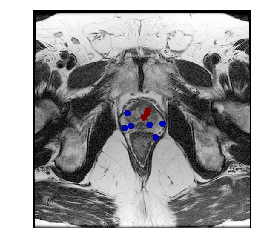

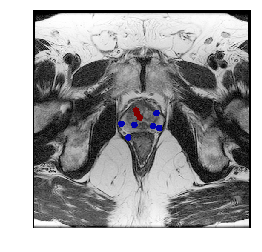

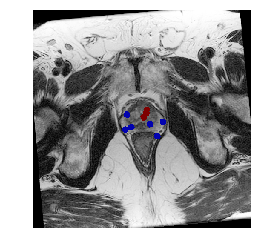

In [30]:
### Playground / Viewer

"""
This is a simple wrapper along matplotlib's `imshow` function, which 
allows to produce images with pixel-dependent transparency.
"""
import matplotlib
import matplotlib.pyplot as plt

def transp_imshow( data, tvmin=None, tvmax=None, tmax=1.,
                    gam=1., cmap='Blues', **kwargs ) :
    """
    Displays the 2d array `data` with pixel-dependent transparency.
    Parameters
    ----------
    data: 2d numpy array of floats or ints
        Contains the data to be plotted as a 2d map
    tvmin, tvmax: floats or None, optional
        The values (for the elements of `data`) that will be plotted
        with minimum opacity and maximum opacity, respectively.
        If no value is provided, this uses by default the arguments
        `vmin` and `vmax` of `imshow`, or the min and max of `data`.
    tmax: float, optional
        Value between 0 and 1. Maximum opacity, which is reached
        for pixel that have a value greater or equal to `tvmax`.
        Default: 1.
    gam: float, optional
        Distortion of the opacity with pixel-value.
        For `gam` = 1, the opacity varies linearly with pixel-value
        For `gam` < 1, low values have higher-than-linear opacity
        For `gam` > 1, low values have lower-than-linear opacity
    cmap: a string or a maplotlib.colors.Colormap object
        Colormap to be used
    kwargs: dict
        Optional arguments, which are passed to matplotlib's `imshow`.
    """
    # Determine the values between which the transparency will be scaled
    if 'vmax' in kwargs :
        vmax = kwargs['vmax']
    else :
        vmax = data.max()
    if 'vmin' in kwargs :
        vmin = kwargs['vmin']
    else :
        vmin = data.min()
    if tvmax is None:
        tvmax = vmax
    if tvmin is None:
        tvmin = vmin

    # Rescale the data to get the transparency and color
    color = (data-vmin)/(vmax-vmin)
    color[color > 1.] = 1.
    color[color < 0.] = 0.
    transparency = tmax*(data-tvmin)/(tvmax-tvmin)
    transparency[transparency > 1.] = 1
    transparency[transparency < 0.] = 0.
    # Application of a gamma distortion
    transparency = tmax * transparency**gam

    # Get the colormap
    if isinstance( cmap, matplotlib.colors.Colormap ):
        colormap = cmap
    elif type(cmap) == str:
        colormap = getattr( plt.cm, cmap )
    else:
        raise ValueError('Invalid type for argument `cmap`.')
    
    # Create an rgba stack of the data, using the colormap 
    rgba_data = colormap( color )
    # Modify the transparency
    rgba_data[:,:,3] = transparency

    plt.imshow( rgba_data, **kwargs )



T2dir = '/data/prostate/postimages/Augmented/'   # also ADC dir
coredir = '/data/prostate/postimages/AugmentedLabels/'


os.chdir(T2dir)


accession = '8099139'
# read files into images
#T2file = '8099139_T2.mha'
#corefile = '8099139_T2_cores_r3_gAll.mha'

#T2file = '8099139_T2_flip0_rotateL04.mha'
#corefile = '8099139_T2_flip0_rotateL04_cores_r3_gAll.mha'

slicei = 9

T2file = accession + '_T2.mha'
corefile = accession + '_cores_r3_gAll.mha'
T2image = sitk.ReadImage(os.path.join(T2dir, T2file), sitk.sitkUInt8)
coreimage = sitk.ReadImage(os.path.join(coredir, corefile), sitk.sitkUInt8)
plt.figure()
plt.axis('off')
plt.imshow(sitk.GetArrayFromImage(T2image)[slicei,:,:], cmap='gray')
transp_imshow(sitk.GetArrayFromImage(coreimage)[slicei,:,:], cmap='seismic', gam=0.01)

T2file = accession + '_T2_flip1.mha'
corefile = accession + '_cores_r3_gAll_flip1.mha'
T2image = sitk.ReadImage(os.path.join(T2dir, T2file), sitk.sitkUInt8)
coreimage = sitk.ReadImage(os.path.join(coredir, corefile), sitk.sitkUInt8)
plt.figure()
plt.axis('off')
plt.imshow(sitk.GetArrayFromImage(T2image)[slicei,:,:], cmap='gray')
transp_imshow(sitk.GetArrayFromImage(coreimage)[slicei,:,:], cmap='seismic', gam=0.01)

T2file = accession + '_T2_flip0_rotateR05.mha'
corefile = accession + '_cores_r3_gAll_flip0_rotateR05.mha'
T2image = sitk.ReadImage(os.path.join(T2dir, T2file), sitk.sitkUInt8)
coreimage = sitk.ReadImage(os.path.join(coredir, corefile), sitk.sitkUInt8)
plt.figure()
plt.axis('off')
plt.imshow(sitk.GetArrayFromImage(T2image)[slicei,:,:], cmap='gray')
transp_imshow(sitk.GetArrayFromImage(coreimage)[slicei,:,:], cmap='seismic', gam=0.01)

In [3]:
imgoripat = np.load('/data/prostate/patdbdata/8099139_11771482_20150826_imgoripat.npy')
imgpospat = np.load('/data/prostate/patdbdata/8099139_11771482_20150826_imgpospat.npy')

print(imgoripat)
print(imgpospat)

[ 1. -0.  0. -0.  1.  0.]
[[ -98.9161 -131.991   -50.8202]
 [ -98.9161 -131.991   -46.8202]
 [ -98.9161 -131.991   -42.8202]
 [ -98.9161 -131.991   -38.8202]
 [ -98.9161 -131.991   -34.8202]
 [ -98.9161 -131.991   -30.8202]
 [ -98.9161 -131.991   -26.8202]
 [ -98.9161 -131.991   -22.8202]
 [ -98.9161 -131.991   -18.8202]
 [ -98.9161 -131.991   -14.8202]
 [ -98.9161 -131.991   -10.8202]
 [ -98.9161 -131.991    -6.8202]
 [ -98.9161 -131.991    -2.8202]
 [ -98.9161 -131.991     1.1798]
 [ -98.9161 -131.991     5.1798]
 [ -98.9161 -131.991     9.1798]
 [ -98.9161 -131.991    13.1798]
 [ -98.9161 -131.991    17.1798]
 [ -98.9161 -131.991    21.1798]
 [ -98.9161 -131.991    25.1798]
 [ -98.9161 -131.991    29.1798]
 [ -98.9161 -131.991    33.1798]
 [ -98.9161 -131.991    37.1798]
 [ -98.9161 -131.991    41.1798]]


In [23]:
T2dir = '/data/prostate/postimages/PostImages2/'   # also ADC dir

os.chdir(T2dir)

for ADCfile in glob.glob('*ADCresampled.mha'):
    accession = ADCfile.split('_')[0]

    # read files into images
    T2file = accession + '_T2.mha'
    T2path = os.path.join(T2dir, T2file)
    T2image = sitk.ReadImage(T2path, sitk.sitkFloat32)

    print(accession)
    print(T2image.GetDirection())
    print('------')

12921995
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11313399
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12882687
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
13257700
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11862185
(1.0, 0.0, 0.0, 0.0, 0.9868557166048625, -0.1616038198939104, 0.0, 0.1616038198939104, 0.9868557166048625)
------
9190612
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12311034
(1.0, -4.897e-12, 0.0, 4.897e-12, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8351469
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10361346
(1.0, 0.0, 0.0, 0.0, 0.9999838742973997, -0.005679009170822453, 0.0, 0.005679009170822453, 0.9999838742973997)
------
8740660
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10885699
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8157429
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10415571
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12363597
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
----

11576254
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12347884
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8353255
(1.0, 0.0, 0.0, 0.0, 0.9997642948352878, -0.021710706402591495, 0.0, 0.021710706402591495, 0.9997642948352878)
------
8525053
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8286809
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10045846
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8485967
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12577641
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8410022
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9136575
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9030052
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11086709
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8689817
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8312996
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11035685
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8395884
(-1.0,

12866163
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8204609
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11155178
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8448102
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
13168079
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
7851098
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8472767
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8530541
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8489061
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12824134
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8548148
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12646676
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8703719
(1.0, 2.05103e-10, 0.0, -2.05103e-10, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11303233
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
7974202
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8183896
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8

11444213
(0.9999607169486379, 0.0, 0.008863665131674182, 0.0, 1.0000000000000002, 0.0, -0.008863665131674183, 0.0, 0.9999607169486376)
------
8882452
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12103128
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9065262
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8642705
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8717325
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9040847
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8847361
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8706132
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12313072
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9138818
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11489909
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11848747
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12133279
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8937769
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------

8575763
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8353683
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10303879
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10968512
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10612163
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9175650
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10910754
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8978473
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12738192
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8543752
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8346275
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12947281
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11504058
(0.9990829910958949, -0.0018921209042081187, 0.04277378614717007, 0.002251913883720459, 0.999962477862799, -0.00836491185556486, -0.04275635375871388, 0.008453564039795355, 0.9990497642601617)
------
8608557
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

9119906
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10964865
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10295772
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8908308
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8415388
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9040914
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11741701
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8237670
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
7980879
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8899253
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12353505
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8254675
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9109924
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11633232
(0.9999979075744098, 0.0, -0.002045689810925516, 0.0, 1.0, 0.0, 0.0020456898109255162, 0.0, 0.9999979075744095)
------
13287687
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10505807
(1.0

7990185
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9117829
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
7860219
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10254306
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10905105
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
7933126
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12175531
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8380949
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8588809
(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
------
11823060
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
8285774
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
9102068
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10070612
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
10310905
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
11802783
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
12304086
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
------
13200439
(0.99